<a href="https://colab.research.google.com/github/dawi118/dk_kurser_repo/blob/main/dk_kurser_scrape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part 1: URL Discovery

In [5]:
!pip install langdetect

In [6]:
# This notebook discovers and saves all individual course URLs from the KU archive.

# --- Libraries ---
import re
import requests
from bs4 import BeautifulSoup, Tag
from urllib.parse import urljoin, urlparse
import time
from langdetect import detect, DetectorFactory
import html
import unicodedata
import json
import logging
from pathlib import Path
import matplotlib.pyplot as plt

# --- Config ---
BASE_URL = "https://kurser.ku.dk"
ARCHIVE_PATH = "/archive"
ARCHIVE_ROOT = f"{BASE_URL}{ARCHIVE_PATH}/"   # 'https://kurser.ku.dk/archive/'
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
OUTPUT_FILE = "all_course_urls.txt"
PAUSE_BETWEEN_COURSES = 0.4

# --- Regex helpers (for managing inconsistent URL formatting)---
YEAR_RE        = re.compile(r"^/?archive/(\d{4}-\d{4})/?$")
BOARD_RE_TPL   = r"^(?:/?archive/)?{year}/(?!course/)[^/]+/?$"
COURSE_RE_TPL  = r"^(?:/?archive/)?{year}/course/[A-Z0-9]+/?$"

# --- Functions ---

# make_abs: normalises URLs by removing extra whitespace and deduplicating 'archive/' prefix
def make_abs(href: str) -> str:
    href = href.lstrip('/')
    if href.startswith('archive/'):
        href = href[len('archive/'):]             # <- avoid double 'archive/' in URL
    return urljoin(ARCHIVE_ROOT, href)

# get_soup: fetches a URL and returns a BeautifulSoup object for parsing HTML content
def get_soup(url):
    try:
        response = requests.get(url, headers=HEADERS)
        response.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)
        return BeautifulSoup(response.content, 'html.parser')
    except requests.exceptions.RequestException as e:
        print(f"Error fetching {url}: {e}")
        return None

# discover_studyboard_links: finds all study board links for a given year
def discover_studyboard_links(year_soup, year_slug):
    board_links = set()
    board_re = re.compile(BOARD_RE_TPL.format(year=re.escape(year_slug)))
    for a in year_soup.find_all("a", href=True):
        href = a["href"].strip()
        if board_re.match(href) and "/course/" not in href:
            board_links.add(make_abs(href))      # <— patched
    return sorted(board_links)

# discover_course_links_from_board: extracts course links from a study board page
def discover_course_links_from_board(board_soup, year_slug):
    course_links = set()
    course_re = re.compile(COURSE_RE_TPL.format(year=re.escape(year_slug)))
    for a in board_soup.find_all("a", href=True):
        href = a["href"].strip()
        if course_re.match(href):
            course_links.add(make_abs(href))     # <— patched
    return course_links

# --- Main Function Call ---

# discover_course_links_from_year: extracts course links (within study boards) for a given year
def discover_course_links_from_year(year_url):
    print(f"  Scraping year: {year_url}")
    year_soup = get_soup(year_url)
    if not year_soup:
        return set()

    year_slug  = year_url.rstrip("/").split("/")[-1]
    all_courses = set()

    # Discover all study board links for the year
    boards = discover_studyboard_links(year_soup, year_slug)
    print(f"    Found {len(boards)} study boards")

    # Loop through each board URL to uncover course links
    for bd_url in boards:
        bd_soup = get_soup(bd_url)
        if not bd_soup:
            continue
        courses = discover_course_links_from_board(bd_soup, year_slug)
        all_courses.update(courses)
        time.sleep(PAUSE_BETWEEN_COURSES)

    # Console output and file writing
    print(f"    Found {len(all_courses)} course links for this year.")
    with open(OUTPUT_FILE, 'w', encoding='utf-8') as f:
                for course_url in sorted(list(all_courses)):
                    f.write(course_url + "\n")
                print(f"All URLs saved to {OUTPUT_FILE}")
    return all_courses

In [7]:
# --- Execution ---
# 2023-2024 (PoC)
if __name__ == "__main__":
    y2023 = "https://kurser.ku.dk/archive/2023-2024"
    discover_course_links_from_year(y2023)

  Scraping year: https://kurser.ku.dk/archive/2023-2024
    Found 36 study boards
    Found 3152 course links for this year.
All URLs saved to all_course_urls.txt


Part 2: Extracting text from a single site page

In [8]:
# This notebook develops and tests the extraction logic for a single course page

# --- Config ---

# Sample URLs for initial testing
SAMPLE_URL = "https://kurser.ku.dk/archive/2023-2024/course/HFIB00821U"  # English test course ID (append): LOJK10281U, Danish: HFIB00821U
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
PAUSE_BETWEEN_COURSES = 0.4
DetectorFactory.seed = 0                     # reproducible results for langdetect

# --- Helpers (text extraction) ---

# Splitter dictionary: for separating learning outcomes into sections and extracting knowledge/skills/competencies
SECTION_MAP = {
    "knowledge"   : ["knowledge", "viden"],
    "skills"      : ["skills", "færdigheder", "faerdigheder"],
    "competencies": ["competencies", "competence", "competences", "kompetencer"],
}

# Coordinator headings dictionary: for identifying course coordinators on English and Danish pages
COORD_HEADINGS = [
    r'^course\s+coordinators$',     # English
    r'^kursusansvarlige$',          # Danish
]

# --- Functions ---

# clean: normalises text by removing extra whitespace
def clean(text: str | None) -> str | None:
    if not text:
        return text
    return re.sub(r'\s+', ' ', text).strip()

# deaccent: removes accents from characters in a string
def deaccent(txt: str) -> str:
    return ''.join(
        c for c in unicodedata.normalize('NFKD', txt)
        if not unicodedata.combining(c)
    )

# normalise: lower-cases, strips leading bullets/dashes/spaces and trailing punctuation - flag as duplicate
def normalise(txt: str) -> str:
    txt = re.sub(r'^[\s•\-–—]+', '', txt, flags=re.UNICODE)   # leading marks
    txt = txt.lower()
    txt = re.sub(r'[:—\-\s]+$', '', txt)                      # trailing ':'/dash
    return txt.strip()

# parse_email_from_onclick: decodes old multi-arg pattern for email addresses (not functional) - returns raw hex blob instead
def parse_email_from_onclick(onclick_attr):
    if not onclick_attr:
        return None

    # ❶ Old multi-argument variant
    parts = re.findall(r"'([^']+)'", onclick_attr)
    if len(parts) >= 2:
        if "." not in parts[0]:                       # heuristic: looks like a name, not a hex blob
            local  = parts[0]
            domain = '.'.join(parts[1:])
            domain = domain.replace('.', '@', 1)      # first dot → '@'
            return f"{local}@{domain}"

    # ❷ New single-blob variant -> just return it raw for now
    blob_match = re.search(r"'([^']+)'", onclick_attr)
    if blob_match:
        return f"obfuscated:{blob_match.group(1)}"    # keep track for later decoding

    return None

# split_learning_outcomes: robust splitter for learning outcomes - Returns dict with keys 'knowledge' / 'skills' / 'competencies' (En, Da), accepts headings with bullets, dashes, accents, and regex '?'
def split_learning_outcomes(raw_text: str) -> dict[str, str]:
    # build a normalised lookup

    variant2key = {normalise(v): k for k, vs in SECTION_MAP.items() for v in vs}

    # scan the text line by line
    lines = raw_text.splitlines()
    current = None
    buckets = {k: [] for k in SECTION_MAP}

    for line in lines:
        txt_norm = normalise(line)
        matched_key = None
        for variant_norm, key_name in variant2key.items():
        # a heading counts if the normalised variant appears
        # either as a standalone word OR as "<variant>:" in the line
            if f"{variant_norm}:" in txt_norm or variant_norm in txt_norm.split():
                matched_key = key_name
                break
        if matched_key:
            current = matched_key
            continue
        if current:
            buckets[current].append(line.strip())

    # collapse whitespace & return
    clean_bucket = lambda lst: re.sub(r"\s+", " ", " ".join(lst)).strip() or None
    return {k: clean_bucket(v) for k, v in buckets.items()}

# --- Main Function Call ---

# extract_course_data: extracts all required data points from a course page soup object
def extract_course_data(soup, url):
    data = {
        'year': None, 'course_code': None, 'course_title': None,
        'coordinators': None, 'coordinator_emails': None, 'content': None,
        'learning_outcomes': None, 'knowledge': None, 'skills': None,
        'competencies': None, 'language': None, 'level': None, 'web_lang': None
    }

    # 1. Year and Course Code from URL
    parts = urlparse(url).path.strip('/').split('/')
    # URL pattern: ['archive', '2023-2024', 'course', 'LOJK10281U']
    if len(parts) >= 4:
        data['year'] = parts[1]          # '2023-2024'
        data['course_code'] = parts[-1]  # 'LOJK10281U'

    # 2. Course title (keeps "Cancelled" for reference, removes duplicate code)
    h1 = soup.find('h1', class_='courseTitle')
    if h1:
        status_span = h1.find('span')
        status_text = ""
        if status_span:
            status_text = status_span.get_text(strip=True)
            status_span.extract()  # drop from <h1> so it isn’t duplicated
        raw = html.unescape(h1.get_text(" ", strip=True)).replace('\xa0', ' ')
        raw = re.sub(r'\s+', ' ', raw).strip()          # <-- NEW: collapse CR/LF/Tabs to one space
        # raw now like: "LOJK10281U Animals in Society"

        tokens = raw.split(maxsplit=1)
        if tokens:
            # tokens[0] is the code – discard; tokens[1] (if present) is the human title
            title_core = tokens[1] if len(tokens) > 1 else ""
            data['course_title'] = f"{status_text} {title_core}".strip() if status_text else title_core


    # 3. Coordinators and Emails
        names, mails = [], []

    # find the first <h5> whose text matches any accepted heading
    coord_h5 = None
    for pat in COORD_HEADINGS:
        coord_h5 = soup.find('h5', string=re.compile(pat, re.I))
        if coord_h5:
            break                       # stop at the first match

    if coord_h5:
        # the UL that follows the <h5>
        ul = coord_h5.find_next('ul', class_='list-unstyled')
        if ul:
            for li in ul.find_all('li', recursive=False):
                # ---- e-mail (span with onclick="mail(...)") ----
                span = li.find(attrs={'onclick': re.compile(r"mail\(")})
                if span:
                    email = parse_email_from_onclick(span.get('onclick'))
                    if email:
                        mails.append(email)
                    span.extract()       # remove span so name text stays clean

                # ---- coordinator name (remaining li text) ----
                name_text = re.sub(r'\s+', ' ', li.get_text(" ", strip=True))
                if name_text:
                    names.append(name_text)

    # deduplicate while preserving order
    def dedup(seq):
        seen, out = set(), []
        for x in seq:
            if x not in seen:
                seen.add(x); out.append(x)
        return out

    data['coordinators']        = dedup(names)  or None
    data['coordinator_emails']  = dedup(mails)  or None

    # 4. Content
    content_div = soup.find('div', class_='course-item course-content')
    if content_div:
        data['content'] = content_div.get_text(separator=' ', strip=True)

    # 5. Learning Outcomes (main container)
    learning_div = soup.find('div', class_='course-description')
    if learning_div:
        full_txt = learning_div.get_text("\n", strip=True)
        data['learning_outcomes'] = clean(full_txt)
        sect = split_learning_outcomes(full_txt)
        data.update(sect)          # merges knowledge / skills / competencies



    # 7. Language and Level
    for dl in soup.find_all('dl', class_=re.compile(r'dl[-_]horizontal')):
        for dt in dl.find_all('dt'):
            key_raw = dt.get_text(strip=True).lower()
            dd = dt.find_next_sibling('dd')
            if not dd:
                continue
            val = clean(dd.get_text(" ", strip=True))
            if not val:
                continue

            # ── NEW multilingual matching ──────────────────────────
            if any(tok in key_raw for tok in ('language', 'sprog', 'undervisningssprog')) \
            and not data['language']:
                data['language'] = val

            elif any(tok in key_raw for tok in ('level', 'niveau')) \
                and not data['level']:
                data['level'] = val
            # ───────────────────────────────────────────────────────
        if data['language'] and data['level']:
            break

    # 8. Clean up text output
    for k in ('content', 'learning_outcomes', 'knowledge',
          'skills', 'competencies'):
        data[k] = clean(data[k])

    # 9. Detect page language (content-based)
    sample_text = (
        data['content']
        or data['learning_outcomes']
        or data['course_title']
        or ''
    )

    try:
        lang_code = detect(sample_text) if sample_text else 'unknown'
    except Exception:
        lang_code = 'unknown'
    data['web_lang'] = lang_code              # e.g. 'en', 'da', 'unknown'
    return data

In [9]:
# --- Execution ---
if __name__ == "__main__":
    print(f"Testing extraction on sample URL: {SAMPLE_URL}")
    sample_soup = get_soup(SAMPLE_URL)

    if sample_soup:
        course_data = extract_course_data(sample_soup, SAMPLE_URL)

        # Pretty print the result for verification
        import json, pprint
        print("\n--- Extracted Data ---")
        print(json.dumps(course_data, indent=1, ensure_ascii=False))
        print("----------------------")
    else:
        print("Failed to retrieve sample page for testing.")

Testing extraction on sample URL: https://kurser.ku.dk/archive/2023-2024/course/HFIB00821U

--- Extracted Data ---
{
 "year": "2023-2024",
 "course_code": "HFIB00821U",
 "course_title": "FILO Videnskabsfilosofi og anvendt filosofi",
 "coordinators": [
  "Thor Grünbaum"
 ],
 "coordinator_emails": [
  "obfuscated:3-8376814f77847c3d7a843d737a"
 ],
 "content": "Kursusindhold Kurset er delt i to moduler: Videnskabsfilosofi og anvendt filosofi Modul 1: Videnskabsfilosofi I Videnskabsfilosofi vil vi introducere til nyere diskussioner i videnskabsfilosofi. Særligt fokus ligger på at forstå forskellige videnskabers rolle i et demokratisk samfund. Undervisningen dækker centrale emner i videnskabsfilosofi, herunder videnskabelige paradigmer, evidens, lovmæssigheder, modeller, forklaringer, realisme/konstruktivisme, centrale træk ved naturvidenskab og samfundsvidenskab samt forholdet mellem videnskab og demokrati. Modul 2: Anvendt filosofi I Anvendt filosofi introduceres de studerende til generell

Part 3: Extracting text from multiple courses over a single study board

In [10]:
# --- Config ---
TARGET_YEAR  = "2023-2024"                     # change if needed
YEAR_URL     = f"https://kurser.ku.dk/archive/{TARGET_YEAR}"
PAUSE_BETWEEN_COURSES = 0.4                    # avoid overwhelming the server
OUT_FILE     = Path(f"courses_{TARGET_YEAR}_board.json")

# Reference base URL for the target year
print("Target year:", YEAR_URL)

Target year: https://kurser.ku.dk/archive/2023-2024


In [11]:
# --- Execution ---
# Fetch the year page soup
year_soup = get_soup(YEAR_URL)

# Reuse discover_studyboard_links() from previous notebook (remember to run it first)
board_list = discover_studyboard_links(year_soup, TARGET_YEAR)
if not board_list:
    raise RuntimeError("No study boards found – HTML structure likely changed.")
first_board_url = board_list[0]
print("First study board URL →", first_board_url)

# Fetch the first board soup and show course links
board_soup = get_soup(first_board_url)
course_urls = discover_course_links_from_board(board_soup, TARGET_YEAR)
print(f"{len(course_urls)} course URLs discovered on the board")

# Initialise lists for records and failures when extracting web pages
records = []
failed   = []

for url in course_urls:
    soup = get_soup(url)
    if not soup:
        failed.append(url)
        continue
    try:
        rec = extract_course_data(soup, url)
        records.append(rec)
    except Exception as e:
        logging.exception("Parse fail on %s", url)
        failed.append(url)
    time.sleep(PAUSE_BETWEEN_COURSES)

print(f"✅  Parsed {len(records)} courses   ❌  Failed {len(failed)}")

First study board URL → https://kurser.ku.dk/archive/2023-2024/STUDNÆVN_4761
133 course URLs discovered on the board
✅  Parsed 133 courses   ❌  Failed 0


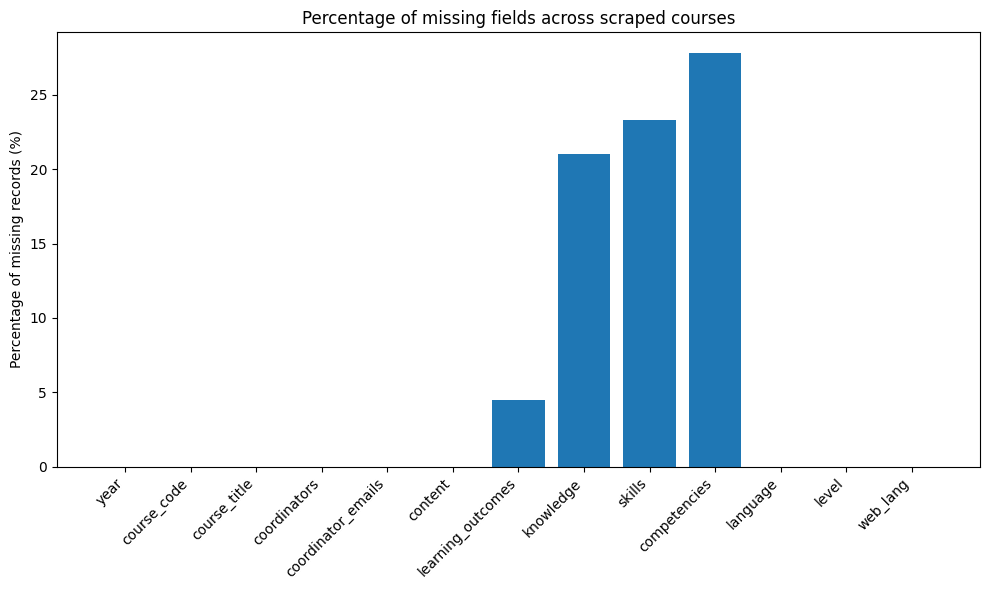

In [12]:
# --- QA ---

# Define fields for audit
FIELDS = [
    "year", "course_code", "course_title",
    "coordinators", "coordinator_emails",
    "content", "learning_outcomes",
    "knowledge", "skills", "competencies",
    "language", "level", "web_lang"
]

def is_missing(value):
    """
    True if `value` is None, empty string (after strip),
    or an empty list / tuple / set.
    """
    if value is None:
        return True
    if isinstance(value, str):
        return value.strip() == ""
    if isinstance(value, (list, tuple, set)):
        return len(value) == 0
    return False

# calculate missing counts
missing_counts = {fld: 0 for fld in FIELDS}
for rec in records:
    for fld in FIELDS:
        if is_missing(rec.get(fld)):
            missing_counts[fld] += 1

# Visualize in bar chart scaled to total records
total_records = len(records)
scaled_missing_counts = {fld: (count / total_records) * 100 for fld, count in missing_counts.items()}

plt.figure(figsize=(10, 6))
plt.bar(scaled_missing_counts.keys(), scaled_missing_counts.values())
plt.xticks(rotation=45, ha="right")
plt.ylabel("Percentage of missing records (%)")
plt.title("Percentage of missing fields across scraped courses")
plt.tight_layout()
plt.show()


In [13]:
# --- Save Results ---
with OUT_FILE.open("w", encoding="utf-8") as f:
    json.dump(records, f, ensure_ascii=False, indent=2)

# Notify user
print("Saved →", OUT_FILE.resolve())

Saved → /content/courses_2023-2024_board.json
